## Evaluation Notebook

### 0 - Important Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np

import os
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from LoadRealRunningJumping import *
from LoadSyntheticRunningJumping import *

from dataLoader import *

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


### 1 - Load Data

In [3]:
data_path = os.path.abspath('/workspaces/container-workspace/DAHAR_GANs')
pre_trained_models_path = os.path.abspath('/workspaces/container-workspace/tts-gan/pre-trained-models')

data_path, pre_trained_models_path

('/workspaces/container-workspace/DAHAR_GANs',
 '/workspaces/container-workspace/tts-gan/pre-trained-models')

In [4]:
original_set = daghar_load_dataset(class_name='Running')

return single class data and labels, class is Running
data shape is (15989, 3, 1, 30)
label shape is (15989,)


/workspaces/container-workspace/tts-gan/dataLoader.py:318: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.class_data = torch.tensor(class_data)


In [6]:
syn_set = Single_Class_Synthetic_Dataset(path = '/workspaces/container-workspace/tts-gan/logs/Testing_other_datasets_2024_10_11_20_17_44/Model/checkpoint',
                                         seq_len=30)


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(path,  map_location=torch.device('c

Checkpoint epochs: 4
(600, 3, 1, 30)
(600, 1)


In [11]:
random_syn_set = Single_Class_Synthetic_Dataset(path = '/workspaces/container-workspace/tts-gan/logs/Testing_other_datasets_2024_10_11_20_17_44/Model/1_checkpoint',
                                              seq_len=30)

/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(path,  map_location=torch.device('c

Epochs: 0
(600, 3, 1, 30)
(600, 1)


In [12]:
original_data_loader = data.DataLoader(original_set, batch_size=1, num_workers=1, shuffle=True)
syn_data_loader = data.DataLoader(syn_set, batch_size=1, num_workers=1, shuffle=True)
random_data_loader = data.DataLoader(random_syn_set, batch_size=1, num_workers=1, shuffle=True)

In [13]:
def extract_dataloader(dataloader):
    data = []
    for i, (real_sig, label) in enumerate(dataloader):
        real_sig = real_sig.cpu().detach().numpy()
        sig = real_sig.reshape(real_sig.shape[1], real_sig.shape[3])
        data.append(sig)
    
    return np.array(data)

In [70]:

syn_data = extract_dataloader(syn_data_loader)
random_data = extract_dataloader(random_data_loader)
original_data = extract_dataloader(original_data_loader)[:len(syn_data)]

original_data.shape, syn_data.shape, random_data.shape

((600, 3, 30), (600, 3, 30), (600, 3, 30))

In [15]:
#Expected float 32 on the input
syn_data = torch.from_numpy(syn_data).unsqueeze(dim=2).type(torch.float)
original_data = torch.from_numpy(original_data).unsqueeze(dim=2).type(torch.float)
random_data = torch.from_numpy(random_data).unsqueeze(dim=2).type(torch.float)

original_data.shape

torch.Size([15989, 3, 1, 30])

### 1.2 - FFT


In [18]:
import torch.fft as fft

#synthetic authors
syn_fft_data = fft.fft(syn_data, dim=-1)

#original
original_fft_data = fft.fft(original_data, dim=-1)

#random
random_fft_data = fft.fft(random_data, dim=-1)

syn_fft_data.shape

torch.Size([600, 3, 1, 30])

### 2 - Face-of the Data

#### Time Domain

In [22]:
time_domain = [original_data.squeeze(dim=2), random_data.squeeze(dim=2), syn_data.squeeze(dim=2)]
c= ['steelblue', 'orangered', 'green']
title = ['Real', 'Random', 'Synth']

In [23]:
def compareGraph(array, c, title, r = None):
    if not r:
        r = torch.randint(0,599, size=(1,)).item()
    temp = array
    print(r)
    fig, axs = plt.subplots(1, len(temp), figsize=(35,5))
    #fig.suptitle('Running', fontsize=30)
    fig.subplots_adjust(wspace=0.1, hspace=0.4)
    for j in range(len(temp)):
        for l in range(3):
            axs[j].plot(temp[j][r][l][:], c=c[l])
        axs[j].set_title(title[j], fontsize=20)

1
2
3
4
5


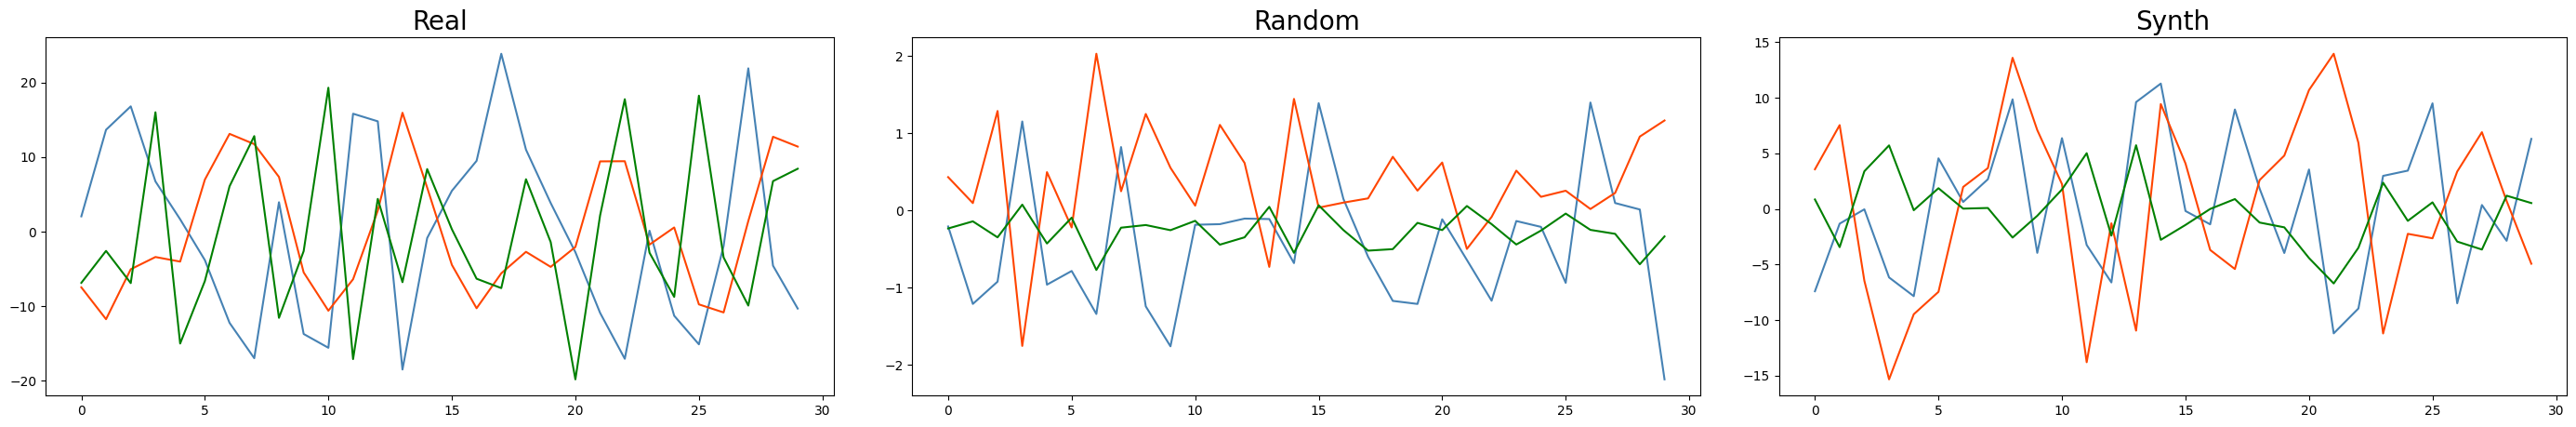

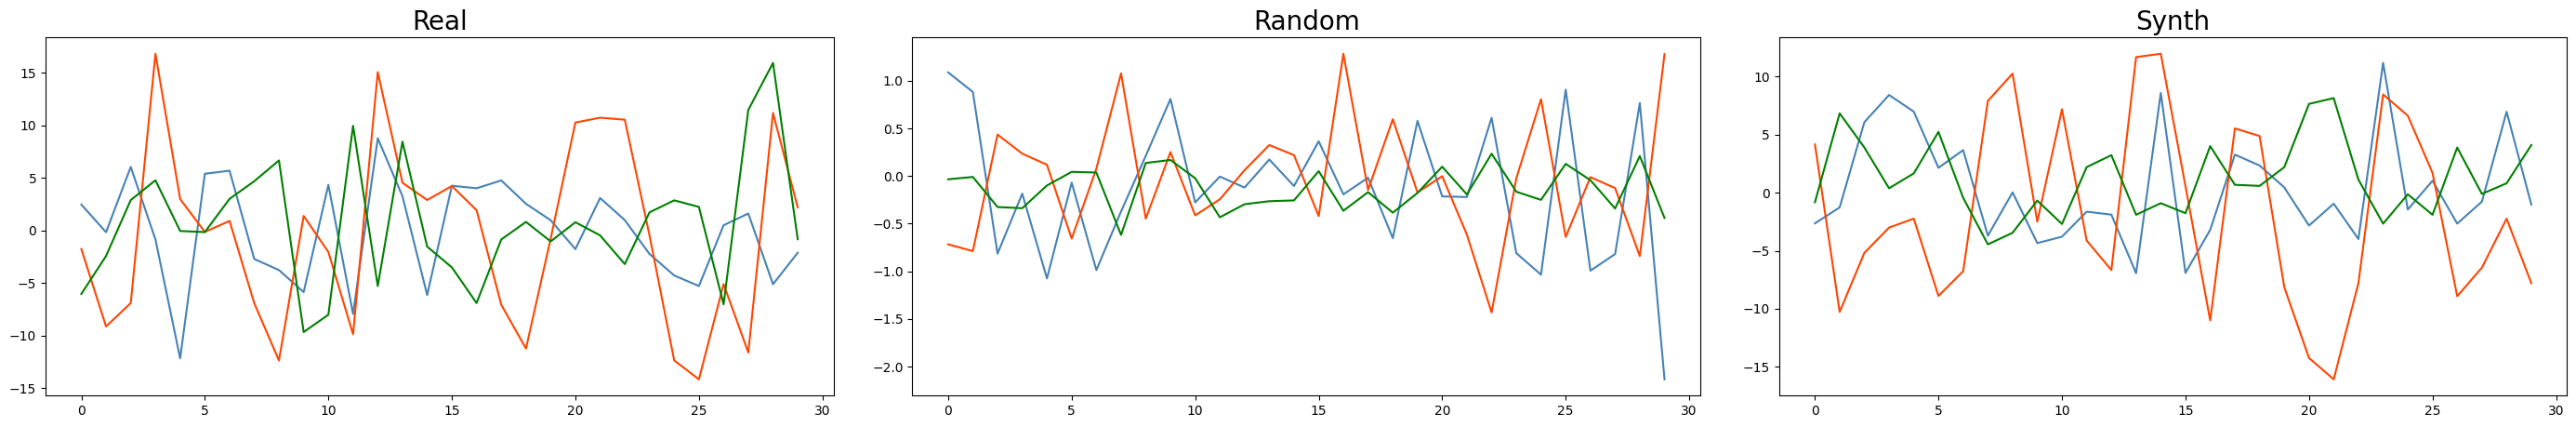

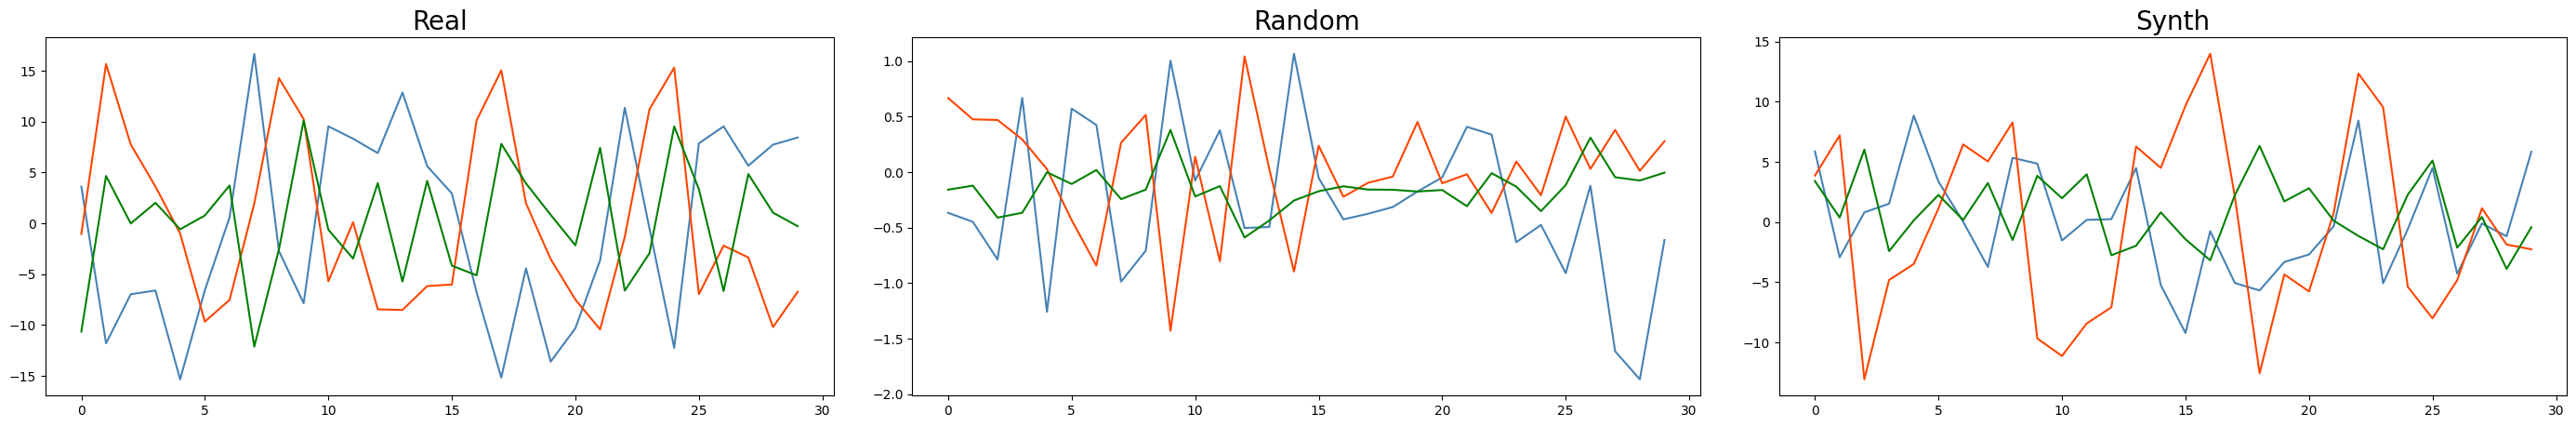

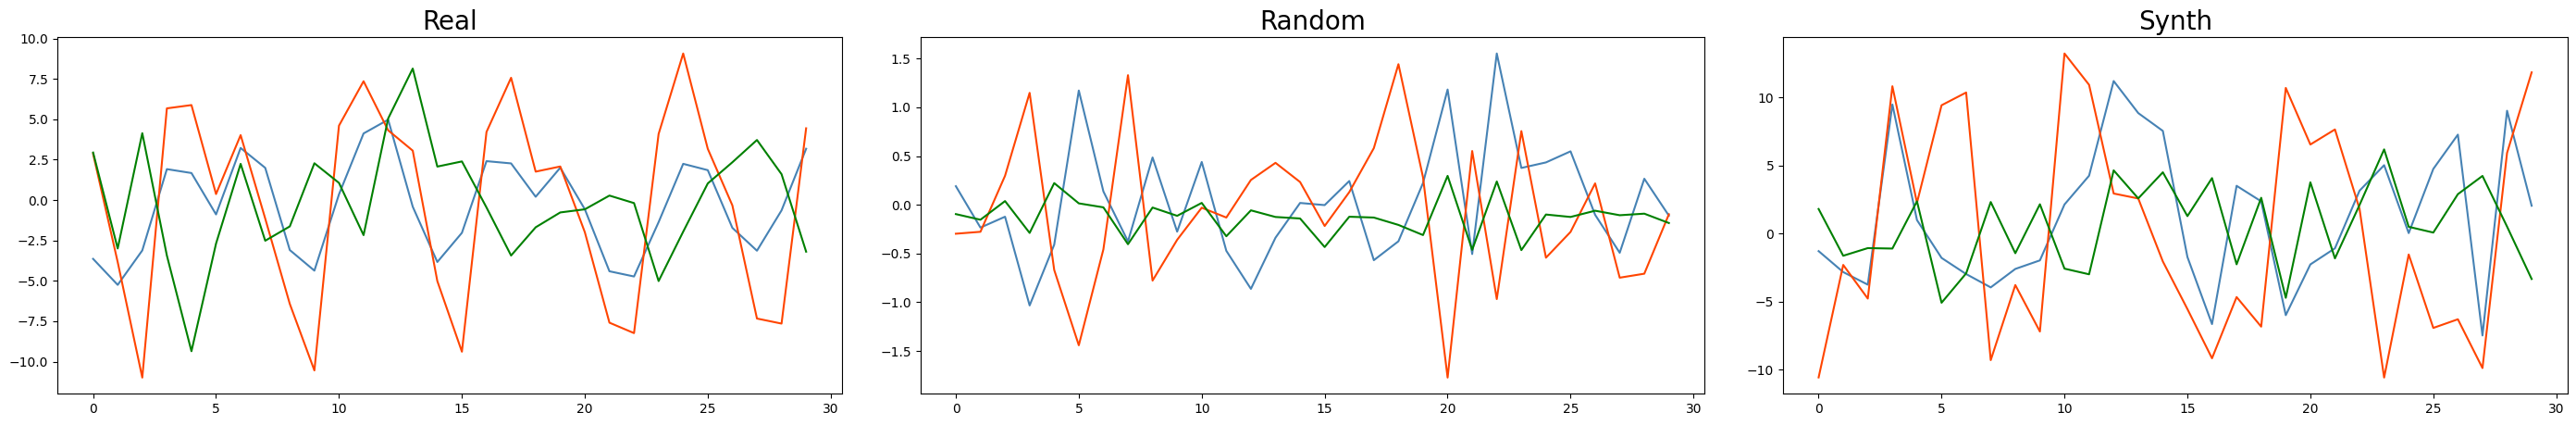

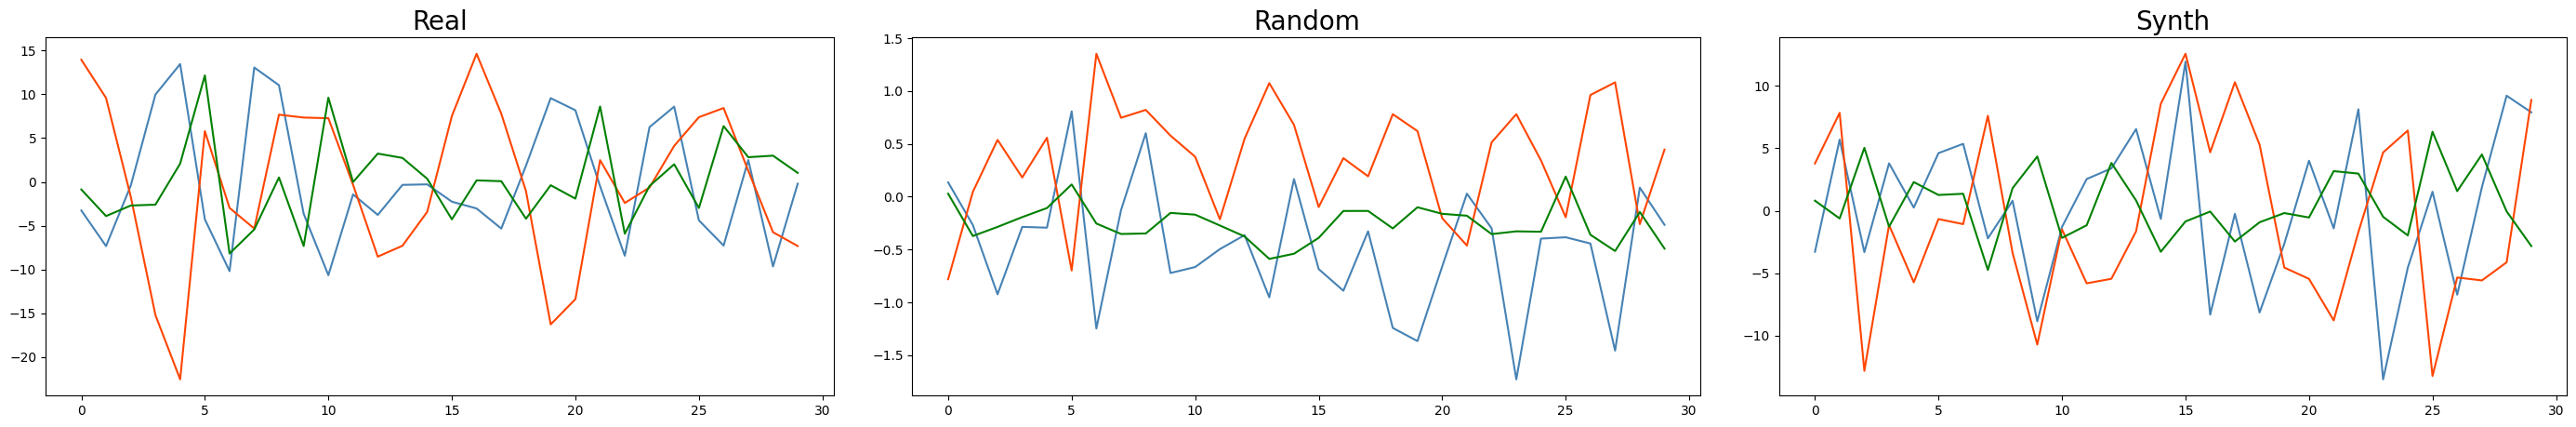

In [29]:
for i in range(5):
    compareGraph(time_domain, c, title, r=i+1)

#### Frequency Domain

1
2
3
4
5


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1085: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


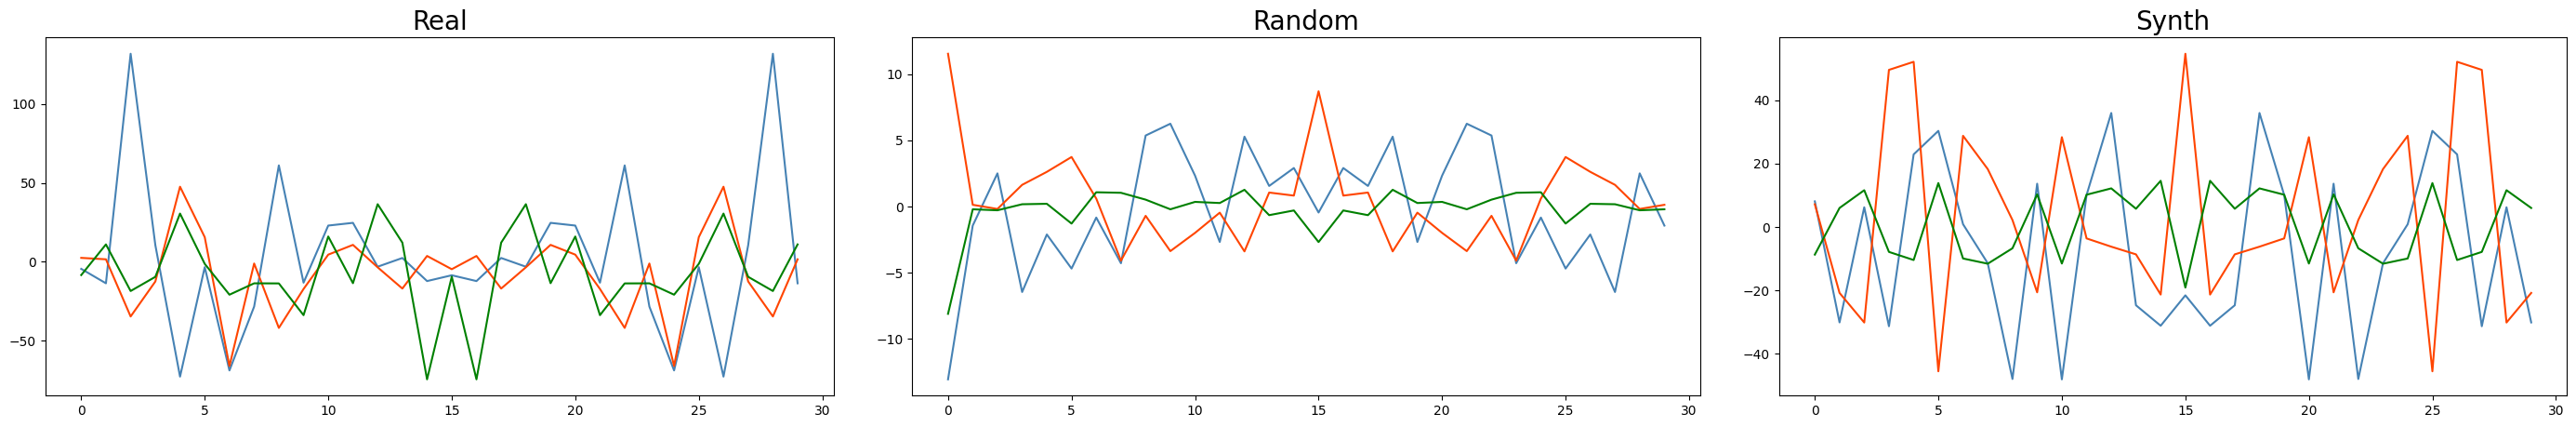

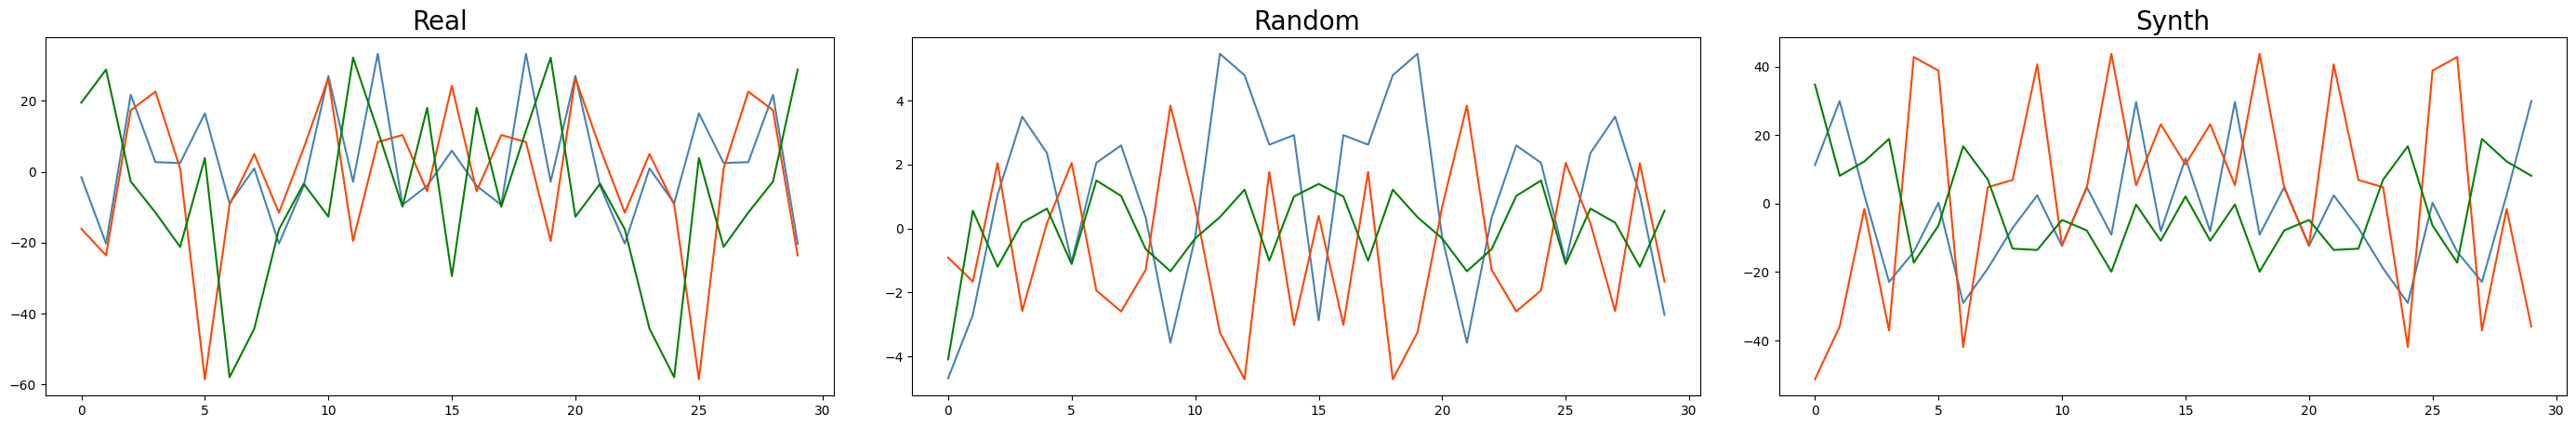

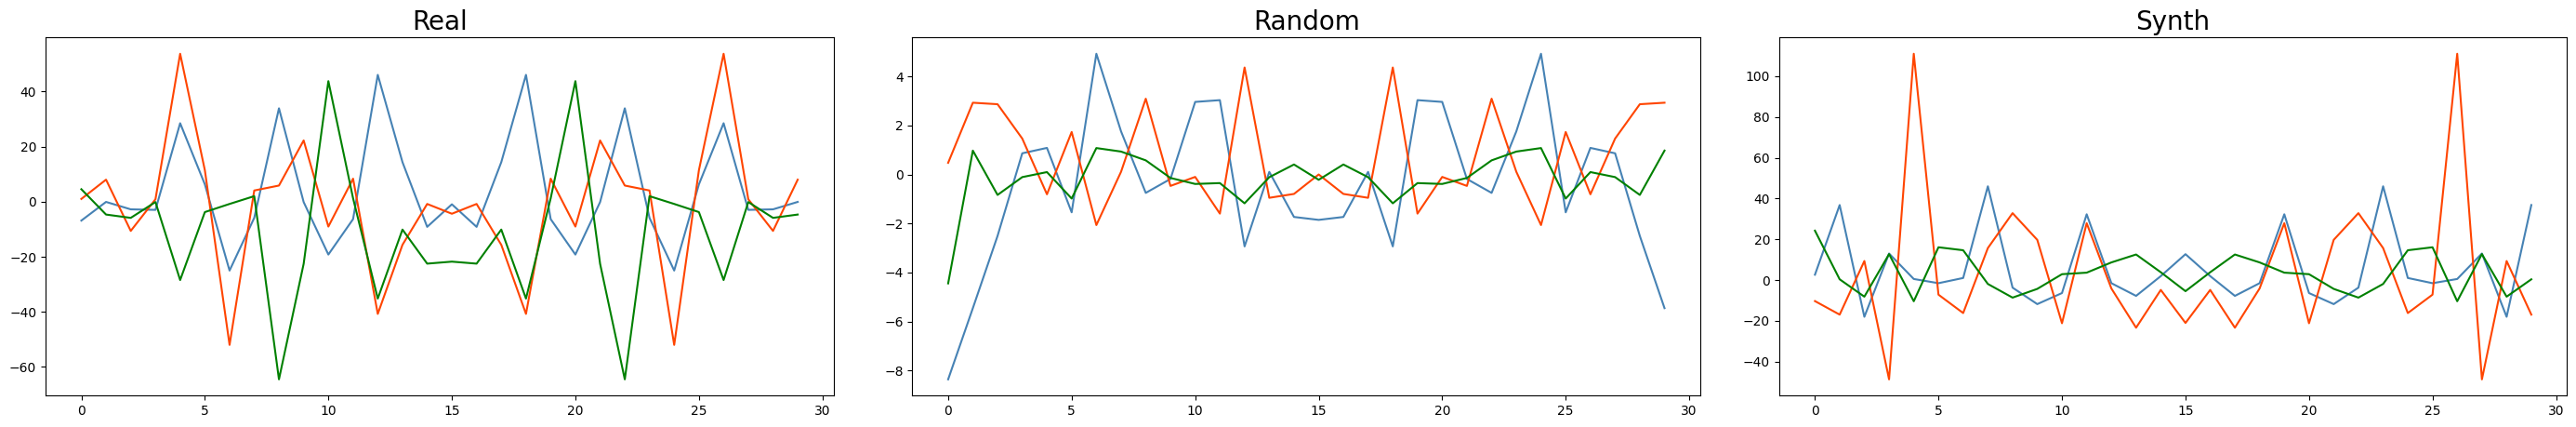

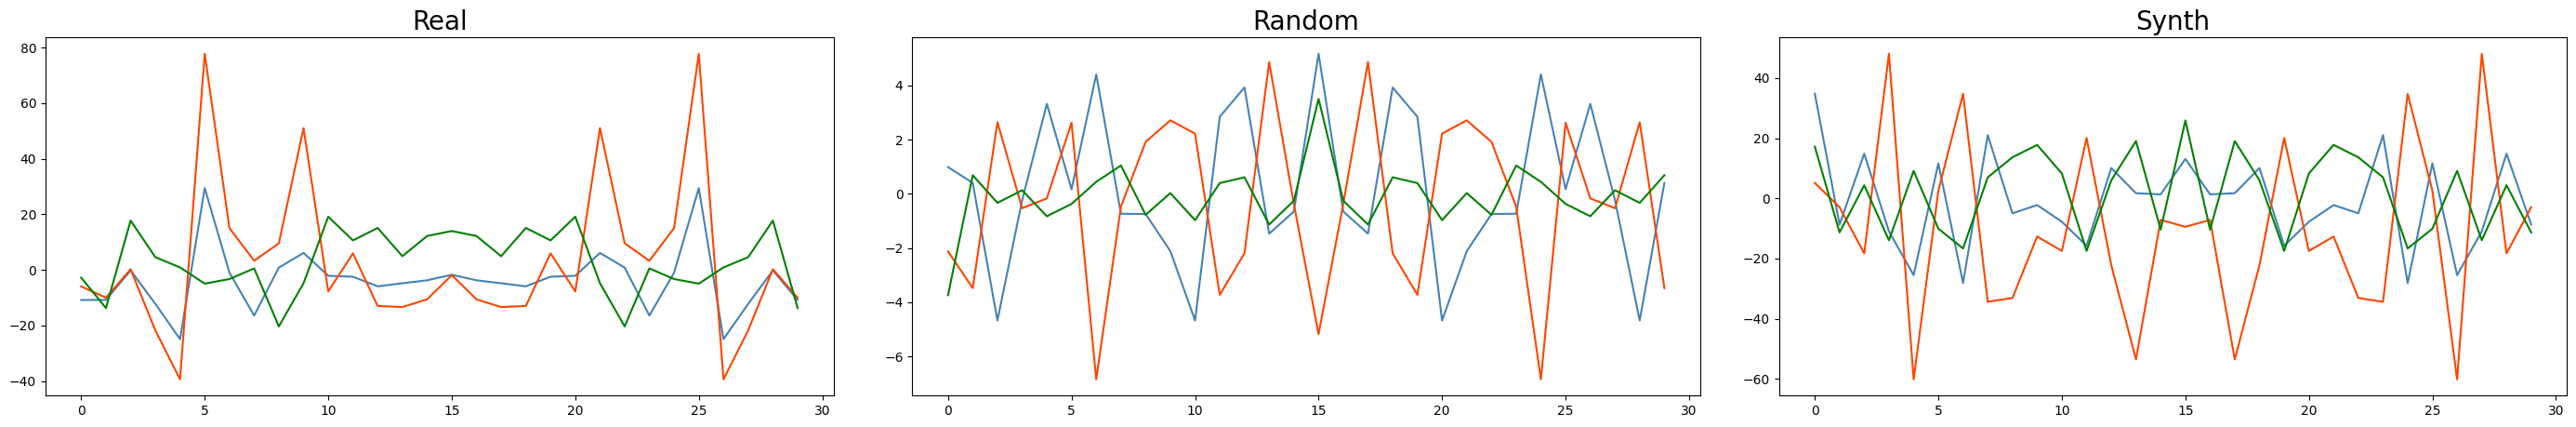

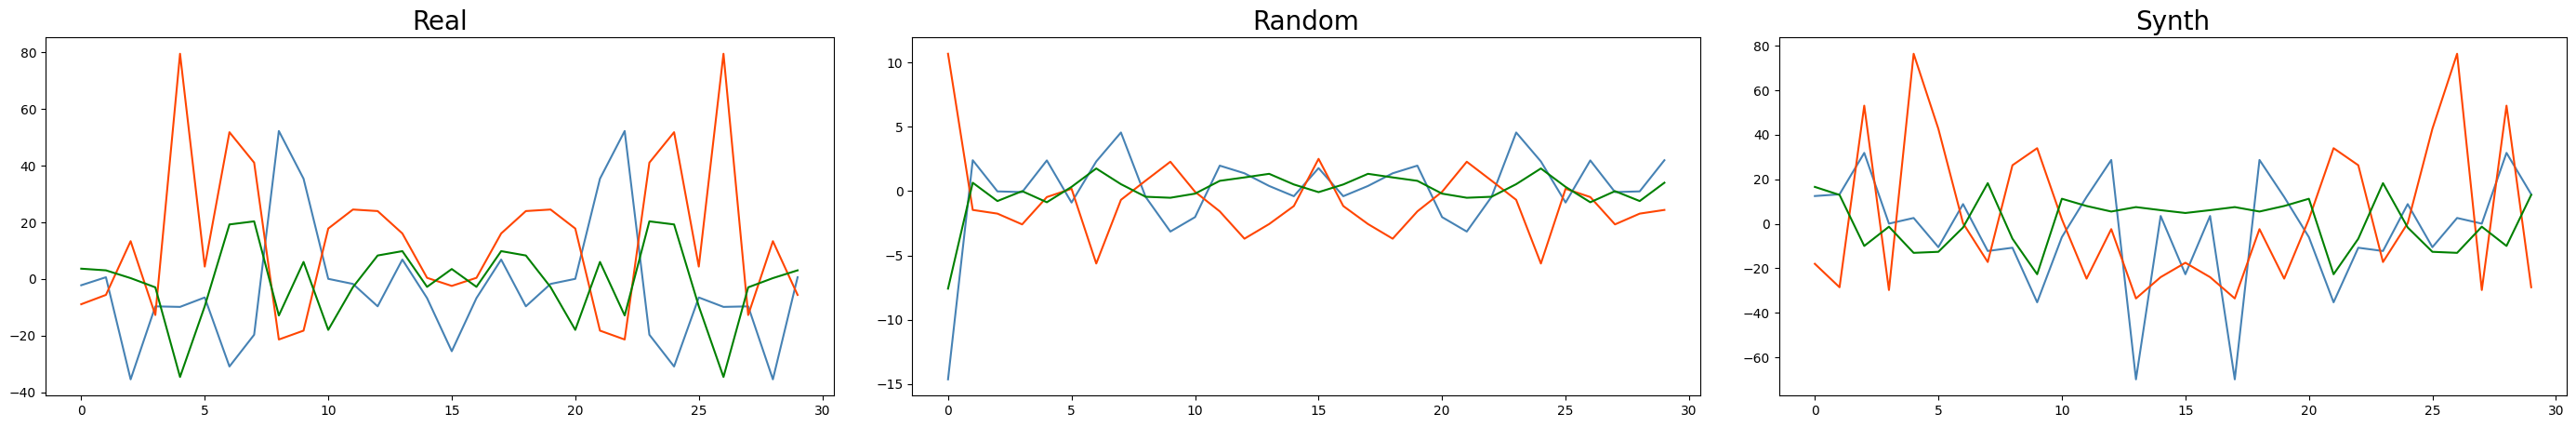

In [31]:
frequency_domain = [original_fft_data.squeeze(dim=2), random_fft_data.squeeze(dim=2), syn_fft_data.squeeze(dim=2)]
for i in range(5):
    compareGraph(frequency_domain, c, title, r=i+1)

### 3 - Feature Extraction


#### Feature Extraction


In [33]:
def rootMeanSquare(data: torch.tensor):
    
    return torch.sqrt((data**2).mean(dim=-1))

In [36]:
def FeatureExtractor(data: torch.tensor, dim: int = -1):
    '''
    A simple feature extractor of several meaningful features from each input
    data sequence. They are the median, mean, standard deviation, variance, root
    mean square, maximum, and minimum values of each input sequence. 

    The tensor is expected to be in shape (600, 3, 1, 150), with 600 of batch, 
    3 channels (x,y,z), height 1 and width 150 (time)

    parameters:
        input:
            data -> The tensor from which we will extract the features
            squeeze -> which dimention we'll squeeze
            dim -> dimention of the time channels (for our purposes is the last one)
    
    '''
    #print(data.shape)

    fmedian = data.median(dim=dim)[0]
    #print(f'median shape: {fmedian.shape}')
    fmean = data.mean(dim=dim)
    #print(f'mean shape: {fmean.shape}')
    fstd = data.std(dim=dim)
    #print(f'STD shape: {fstd.shape}')
    fvar = data.var(dim=dim)
    #print(f'Var shape: {fvar.shape}')
    frms = rootMeanSquare(data)
    #print(f'RMS shape: {frms.shape}')
    fmax = data.max(dim=dim)[0]
    #print(f'max value shape: {fmax.shape}')
    fmin = data.min(dim=dim)[0]
    #print(f'min value shape: {fmin.shape}')
    
    temp = torch.cat((fmedian, fmean, fstd, fvar, frms, fmax, fmin), dim=-1)
    #print(temp.shape)

    return temp.mean(dim=0) ##Take mean of a batch 


result1 = FeatureExtractor(original_data, dim=-1)
result1[:4], result1.shape

(tensor([[-2.9280e-01,  1.8340e-02,  6.3848e+00,  4.9965e+01,  6.2988e+00,
           1.2225e+01, -1.1933e+01],
         [-4.2323e-01, -2.1112e-03,  6.7778e+00,  5.7491e+01,  6.6816e+00,
           1.1855e+01, -1.2565e+01],
         [-9.7172e-02,  1.4709e-02,  4.3928e+00,  2.4023e+01,  4.3389e+00,
           9.3490e+00, -9.2773e+00]]),
 torch.Size([3, 7]))

In [63]:
fa_syn = FeatureExtractor(syn_data)
fa_original = FeatureExtractor(original_data[:len(fa_syn)])
fa_random = FeatureExtractor(random_data)

fa_syn.shape, fa_original.shape, fa_random.shape

(torch.Size([3, 7]), torch.Size([3, 7]), torch.Size([3, 7]))

In [64]:
fa_syn, fa_original, fa_random

(tensor([[ 4.6598e-02,  1.6959e-01,  5.2416e+00,  2.8013e+01,  5.2427e+00,
           1.0937e+01, -1.1133e+01],
         [-1.4481e+00, -4.2365e-01,  7.5612e+00,  5.7912e+01,  7.5303e+00,
           1.3983e+01, -1.3967e+01],
         [ 1.4154e-01,  3.7883e-01,  2.8956e+00,  8.5251e+00,  2.9156e+00,
           6.4069e+00, -5.4326e+00]]),
 tensor([[-2.9426e-01,  7.0085e-03,  6.3605e+00,  4.9114e+01,  6.2751e+00,
           1.2280e+01, -1.1882e+01],
         [-5.0383e-01,  9.4115e-03,  6.6837e+00,  5.6220e+01,  6.5889e+00,
           1.1935e+01, -1.2389e+01],
         [-1.1691e-01,  1.8588e-03,  4.3347e+00,  2.4023e+01,  4.2829e+00,
           9.3274e+00, -9.2214e+00]]),
 tensor([[-0.3149, -0.2824,  0.7160,  0.5225,  0.7819,  1.1914, -1.7692],
         [ 0.1084,  0.1404,  0.6202,  0.3915,  0.6461,  1.4360, -1.1447],
         [-0.1867, -0.1817,  0.1962,  0.0391,  0.2677,  0.2144, -0.5952]]))

### 4 - Jensen Shannon Divergence (The clossest to zero the better)

In [65]:
from scipy.spatial import distance

a = distance.jensenshannon(fa_original[:600], fa_random, axis=1)

a, a.shape, a.sum(), a.mean()

(array([inf, inf, inf], dtype=float32), (3,), inf, inf)

### Testing Cossine Similarity using normal Distribuition

In [47]:
from numpy import random

x = random.normal(loc=1, scale=2, size=(600, 3, 1, 150))
y = random.normal(loc=1, scale=2, size = (600, 3, 1, 150))

In [48]:
x1 = FeatureExtractor(torch.from_numpy(x))
y1 = FeatureExtractor(torch.from_numpy(y))

x1.shape, y1.shape

(torch.Size([3, 7]), torch.Size([3, 7]))

In [60]:
cos_sim = nn.CosineSimilarity(dim=-1)

a = distance.jensenshannon(x1, y1, axis=-1)
b = cos_sim(x1,y1)
a.shape, a.sum(), b.shape, b.mean()

((3,), inf, torch.Size([3]), tensor(1.0000, dtype=torch.float64))

In [59]:
cos_sim = nn.CosineSimilarity(dim=-1)

a = distance.jensenshannon(fa_syn, fa_random, axis=-1)

b = cos_sim(fa_original, fa_syn)
a.shape, a.sum(), b.shape, b.mean()

((3,), inf, torch.Size([3]), tensor(0.9798))

### 5 - Cossine Similarity (The clossest to 1, the better)

Original

As we can see, we have to pass the data through some type of feature extraction

In [67]:
cos_sim = nn.CosineSimilarity(dim=-1)

#############               DADOS SEM FE             ###############

# Calcular a similaridade cosseno para cada par de vetores
syn_similarity = cos_sim(syn_data, original_data[600]) 
random_similarity = cos_sim(original_data[600], random_data)
syn_random_similarity = cos_sim(syn_data, random_data)


# Calcular a média da similaridade cosseno
average_similarity_running = {'synthetic x original': syn_similarity.mean().item(),
                               'random x original': random_similarity.mean().item(),
                               'random x synthetic': syn_random_similarity.mean().item()} 

print(syn_similarity.shape)
print(average_similarity_running)

torch.Size([600, 3, 1])
{'synthetic x original': 0.020234480500221252, 'random x original': -0.021052232012152672, 'random x synthetic': -0.04428326338529587}


Feature Extraction

In [68]:
cos_sim = nn.CosineSimilarity(dim=-1)

#############               DADOS SEM FE             ###############

# Calcular a similaridade cosseno para cada par de vetores
syn_similarity = cos_sim(fa_syn, fa_original) 
random_similarity = cos_sim(fa_original, fa_random)
syn_random_similarity = cos_sim(fa_syn, fa_random)


# Calcular a média da similaridade cosseno
average_similarity_running = {'synthetic x original': syn_similarity.mean().item(),
                               'random x original': random_similarity.mean().item(),
                               'random x synthetic': syn_random_similarity.mean().item()} 

print(syn_similarity.shape)
print(average_similarity_running)

torch.Size([3])
{'synthetic x original': 0.9799795150756836, 'random x original': 0.5093666911125183, 'random x synthetic': 0.6147910952568054}


### 6 - Comparation

#### Data Frame

In [85]:
comparition_simple = [average_similarity_simple,
               average_similarity_sample_simple,
               average_similarity_original_simple_train,
               average_similarity_original_simple_random]

In [86]:
import pandas as pd

df = pd.DataFrame(comparition_simple, 
                  index = ['Autores',
                           'Jaime',
                           'Vini',
                           'Random'])
pd.set_option('display.precision', 4)

df

Running  jumping  Running-jumping  jumping-running
Autores   0.9905   0.9836           0.9802           0.9852
Jaime     0.9909   0.9831           0.9799           0.9861
Vini      0.9903   0.9827           0.9790           0.9843
Random    0.9745   0.9674           0.9678           0.9749

In [87]:
comparition_fa = [average_similarity_fa,
               average_similarity_sample_fa,
               average_similarity_original_fa_train,
               average_similarity_original_fa_random]

In [88]:
import pandas as pd

df = pd.DataFrame(comparition_fa, 
                  index = ['Autores',
                           'Jaime',
                           'Vini',
                           'Random'])
pd.set_option('display.precision', 4)
df

Running  jumping  Running-jumping  jumping-running
Autores   0.9980   0.9988           0.9927           0.9939
Jaime     0.9977   0.9988           0.9925           0.9941
Vini      0.9970   0.9976           0.9911           0.9907
Random    0.9707   0.9701           0.9696           0.9711

#### Data setup for TSNE

#### Time Domain

In [69]:
original = np.transpose(original_data.squeeze(dim=2), (0, 2, 1))
syn = np.transpose(syn_data.squeeze(dim=2), (0, 2, 1))
random = np.transpose(random_data.squeeze(dim=2), (0, 2, 1))

original.shape

torch.Size([15989, 30, 3])

#### Frequency Domain

In [90]:
original_fft = np.transpose(original_data.squeeze(dim=2), (0, 2, 1))
syn_fft = np.transpose(syn_data.squeeze(dim=2), (0, 2, 1))
random_fft = np.transpose(random_data.squeeze(dim=2), (0, 2, 1))

original.shape

real_fft_running = np.transpose(running_ori_fft_data.squeeze(dim=2), (0, 2, 1))
real_fft_jumping = np.transpose(jumping_ori_fft_data.squeeze(dim=2), (0, 2, 1))
syn_fft_running = np.transpose(running_syn_fft_data.squeeze(dim=2), (0, 2, 1))
syn_fft_jumping = np.transpose(jumping_syn_fft_data.squeeze(dim=2), (0, 2, 1))

syn_fft_running_sample = np.transpose(running_syn_fft_sample_data[:600].squeeze(dim=2), (0, 2, 1))
syn_fft_jumping_sample = np.transpose(jumping_syn_fft_sample_data[:600].squeeze(dim=2), (0, 2, 1))

baby_fft_running = np.transpose(running_baby_fft_data.squeeze(dim=2), (0, 2, 1))
baby_fft_jumping = np.transpose(jumping_baby_fft_data.squeeze(dim=2), (0, 2, 1))


train_fft_jumping.shape

torch.Size([600, 150, 3])

#### TSNE Visualization

In [91]:
from sklearn.manifold import TSNE

def TSNE_visualization(running_original, jumping_original, running_synthetic, jumping_synthetic, show=True):

    l = len(running_original)
    idx = np.random.permutation(len(running_original))

    # Data preprocessing
    running_original = np.asarray(running_original)
    running_synthetic = np.asarray(running_synthetic)  
    jumping_original = np.asarray(jumping_original)
    jumping_synthetic = np.asarray(jumping_synthetic)

    running_original = running_original[idx]
    running_synthetic = running_synthetic[idx]
    jumping_original = jumping_original[idx]
    jumping_synthetic = jumping_synthetic[idx]
    

    no, seq_len, dim = running_original.shape  

    for i in range(l):
        if (i == 0):
            prep_running = np.reshape(np.mean(running_original[0,:,:], 1), [1, seq_len])
            prep_running_hat = np.reshape(np.mean(running_synthetic[0,:,:], 1), [1, seq_len])
            prep_jumping = np.reshape(np.mean(jumping_original[0,:,:], 1), [1, seq_len])
            prep_jumping_hat = np.reshape(np.mean(jumping_synthetic[0,:,:], 1), [1, seq_len])

        else:
            prep_running = np.concatenate((prep_running, 
                                        np.reshape(np.mean(running_original[i,:,:],1), [1, seq_len])))
            prep_running_hat = np.concatenate((prep_running_hat, 
                                        np.reshape(np.mean(running_synthetic[i,:,:],1), [1, seq_len])))
            prep_jumping = np.concatenate((prep_jumping,
                                        np.reshape(np.mean(jumping_original[i,:,:], 1), [1, seq_len])))
            prep_jumping_hat = np.concatenate((prep_jumping_hat,
                                        np.reshape(np.mean(jumping_synthetic[i,:,:], 1), [1, seq_len])))
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_running, prep_jumping, prep_running_hat, prep_jumping_hat), axis = 0)
    print(prep_data_final.shape)
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
    print(tsne_results.shape)
    # Plotting
    if not show:
        return tsne_results
    
    f, ax = plt.subplots(1)

    plt.scatter(tsne_results[:600,0], tsne_results[:600,1], 
                c = '#bc5090', alpha = 0.2, label = "Running Original")
    
    plt.scatter(tsne_results[600:1200,0], tsne_results[600:1200,1], 
                c = '#003f5c', alpha = 0.2, label = "Jumping Original")
    
    plt.scatter(tsne_results[1200:1800,0], tsne_results[1200:1800,1], 
                c = '#ffa600', alpha = 0.2, label = "Running Synthetic")
    
    plt.scatter(tsne_results[1800:,0], tsne_results[1800:,1], 
                c = '#00ff00', alpha = 0.2, label = "Jumping Synthetic")

    ax.legend()

    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    #         plt.show()    

    plt.show()

#### Time Domain

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.157166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.426277
[t-SNE] KL divergence after 300 iterations: 2.643561
(2400, 2)


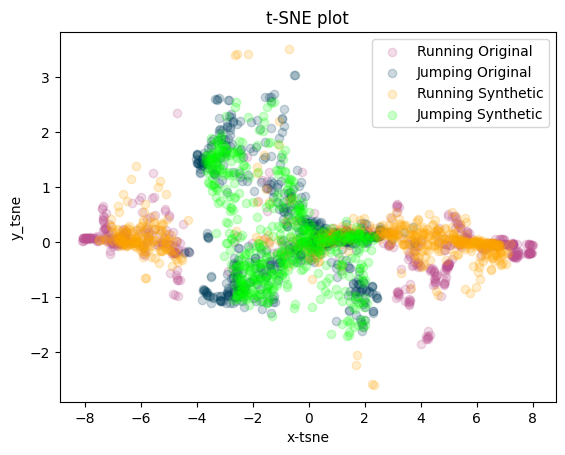

In [92]:
TSNE_visualization(real_running, real_jumping, syn_running, syn_jumping)

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.152151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.407173
[t-SNE] KL divergence after 300 iterations: 2.752459
(2400, 2)


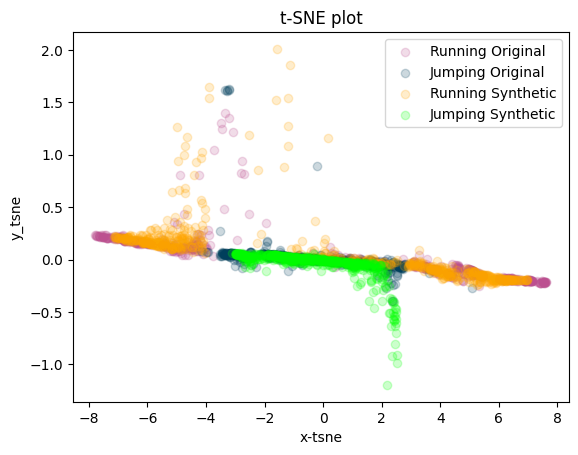

In [93]:
TSNE_visualization(real_running_sample, real_jumping_sample, syn_running_sample, syn_jumping_sample)

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.059547
[t-SNE] KL divergence after 150 iterations with early exaggeration: 74.526711
[t-SNE] KL divergence after 300 iterations: 2.047853
(2400, 2)


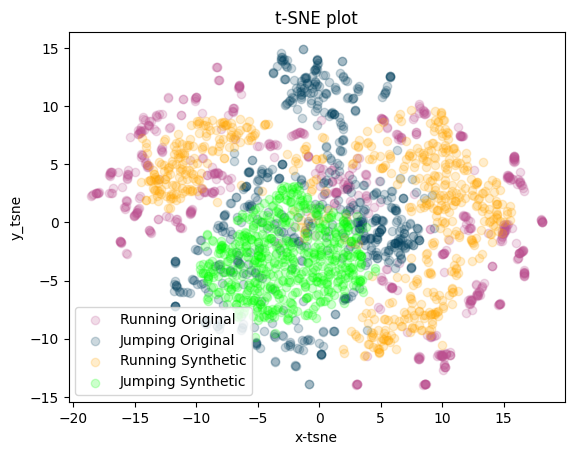

In [94]:
TSNE_visualization(real_running, real_jumping, train_running, train_jumping)

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 1.372108


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.360275
[t-SNE] KL divergence after 300 iterations: 2.863545
(2400, 2)


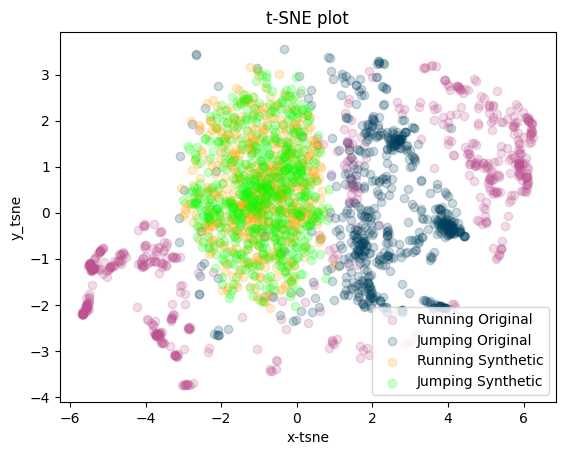

In [95]:
TSNE_visualization(real_running, real_jumping, baby_running, baby_jumping)

#### Frequency Domain

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 16.051308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.179573
[t-SNE] KL divergence after 300 iterations: 1.885179
(2400, 2)


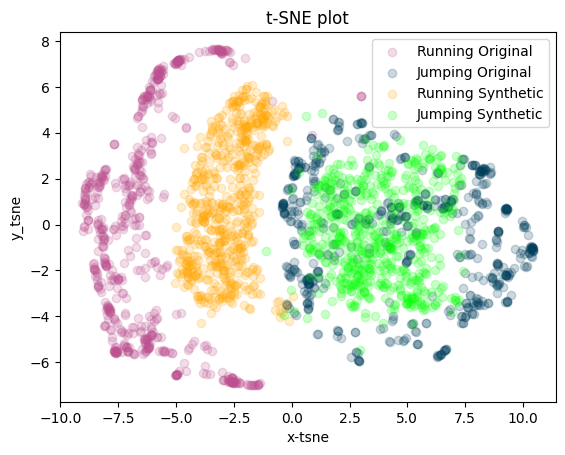

In [96]:
TSNE_visualization(np.abs(real_fft_running), np.abs(real_fft_jumping), np.abs(syn_fft_running), np.abs(syn_fft_jumping))

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 16.069461


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.106796
[t-SNE] KL divergence after 300 iterations: 1.896797
(2400, 2)


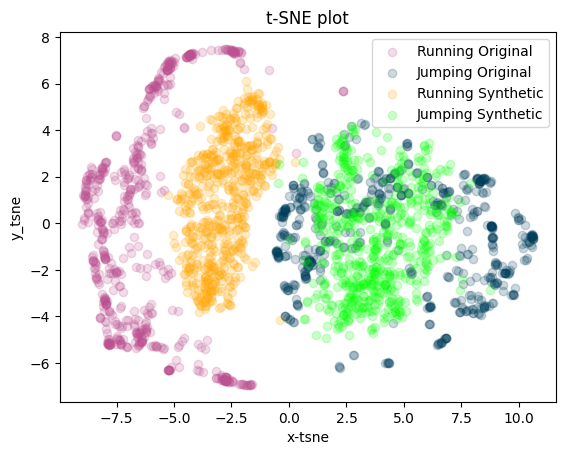

In [97]:
TSNE_visualization(np.abs(real_fft_running), np.abs(real_fft_jumping), np.abs(syn_fft_running_sample), np.abs(syn_fft_jumping_sample))

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 9.735646
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.640381
[t-SNE] KL divergence after 300 iterations: 2.246953
(2400, 2)


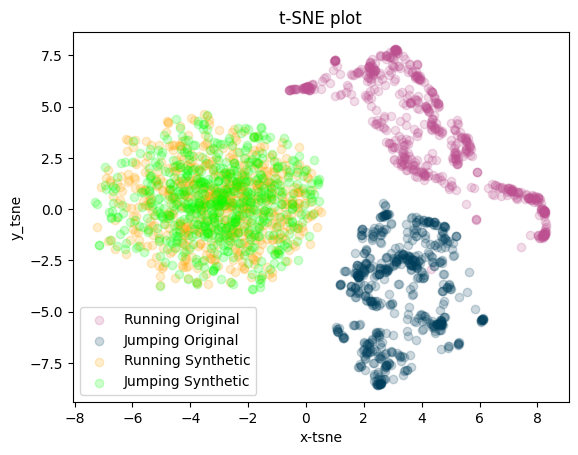

In [98]:
TSNE_visualization(np.abs(real_fft_running), np.abs(real_fft_jumping), np.abs(baby_fft_running), np.abs(baby_fft_jumping))

(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 15.380197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.775963


[t-SNE] KL divergence after 300 iterations: 1.811292
(2400, 2)


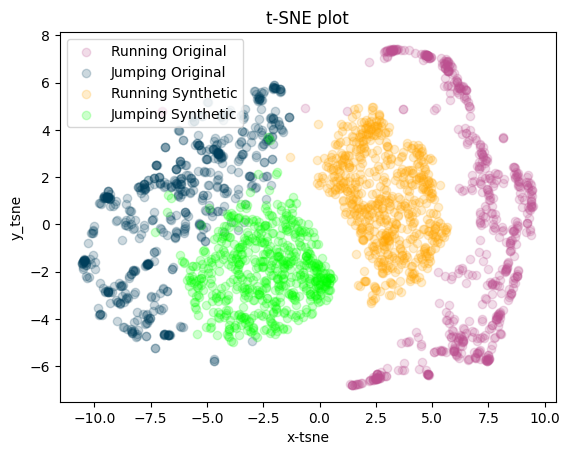

In [99]:
TSNE_visualization(np.abs(real_fft_running), np.abs(real_fft_jumping), np.abs(train_fft_running), np.abs(train_fft_jumping))

### 7 - Visualizing Model Training

In [100]:
def getModelsFromFolder(directory_path: str):
    temp = [os.path.join(directory_path, file) for file in os.listdir(directory_path)]
    return temp

In [101]:
# Specify the directory path
directory_jumping = '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model'
directory_running = '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model'

jumping_file_paths = getModelsFromFolder(directory_jumping)
running_file_paths = getModelsFromFolder(directory_running)
jumping_file_paths, running_file_paths

(['/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/1_checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/4_checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/2_checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/5_checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/3_checkpoint'],
 ['/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/1_checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/4_checkpoint',
  '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/2_checkpoint',
  '/workspaces/container-workspace/tts-gan-main

In [102]:
running_file_paths.sort()
running_file_paths

['/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/1_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/2_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/3_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/4_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/5_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Running_2024_10_02_16_00_30/Model/checkpoint']

In [103]:
jumping_file_paths.sort()
jumping_file_paths

['/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/1_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/2_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/3_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/4_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/5_checkpoint',
 '/workspaces/container-workspace/tts-gan-main/logs/Jumping_test1_2024_10_04_13_34_19/Model/checkpoint']

In [104]:
def trainingVisualization(original_running_data, original_jumping_data, running_model_paths, jumping_model_paths, f=False):
    '''







    '''
    titles = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5']
    fig, axs = plt.subplots(1, len(running_model_paths), figsize=(25,8))
    #fig.suptitle('Time Comparison', fontsize=30)
    for i in range(len(running_model_paths)):
        synthetic_data =  Synthetic_Dataset(Jumping_model_path = jumping_model_paths[i],
                                            Running_model_path = running_model_paths[i],
                                            sample_size=600) 
        
        synthetic_DataLoader = data.DataLoader(synthetic_data, batch_size=1, num_workers=1, shuffle=True)
        synthetic_jumping, synthetic_running = running_jumping_split(synthetic_DataLoader)
        synthetic_jumping = synthetic_jumping.transpose(0, 2, 1)
        synthetic_running = synthetic_running.transpose(0, 2, 1)

        print(synthetic_jumping.shape, synthetic_running.shape)
        
        if f:
            synthetic_running = np.abs(fft.fft(torch.from_numpy(synthetic_running), dim=-1))
            synthetic_jumping = np.abs(fft.fft(torch.from_numpy(synthetic_jumping), dim=-1)) 
            original_running_data = np.abs(original_running_data)
            original_jumping_data = np.abs(original_jumping_data)


        tsne_results = TSNE_visualization(original_running_data, original_jumping_data,
                                          synthetic_running, synthetic_jumping, show=False)
        
        axs[i].scatter(tsne_results[:600,0], tsne_results[:600,1], 
                        c = '#bc5090', alpha = 0.2, label = "Running Original")
        axs[i].scatter(tsne_results[600:1200,0], tsne_results[600:1200,1], 
                        c = '#003f5c', alpha = 0.2, label = "Jumping Original")
        axs[i].scatter(tsne_results[1200:1800,0], tsne_results[1200:1800,1], 
                        c = '#ffa600', alpha = 0.2, label = "Running Synthetic")
        axs[i].scatter(tsne_results[1800:,0], tsne_results[1800:,1], 
                        c = '#00ff00', alpha = 0.2, label = "Jumping Synthetic")
        axs[i].legend()   
        axs[i].set_title(titles[i], fontsize=20)    
    

/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

All epochs are 0


(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 1.383660
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.342056
[t-SNE] KL divergence after 300 iterations: 2.832748
(2400, 2)
All epochs are 0


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.029470
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.361176
[t-SNE] KL divergence after 300 iterations: 2.814365
(2400, 2)
All epochs are 0


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.151846
[t-SNE] KL divergence after 200 iterations with early exaggeration: 74.542252
[t-SNE] KL divergence after 300 iterations: 2.223511
(2400, 2)
All epochs are 0


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.091369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.734764
[t-SNE] KL divergence after 300 iterations: 2.650584
(2400, 2)


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

All epochs are 0
(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.099871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.775803
[t-SNE] KL divergence after 300 iterations: 2.493751
(2400, 2)


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

Running checkpoint: 506
Jumping checkpoint: 834
(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.053112
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.614372
[t-SNE] KL divergence after 300 iterations: 2.540846
(2400, 2)


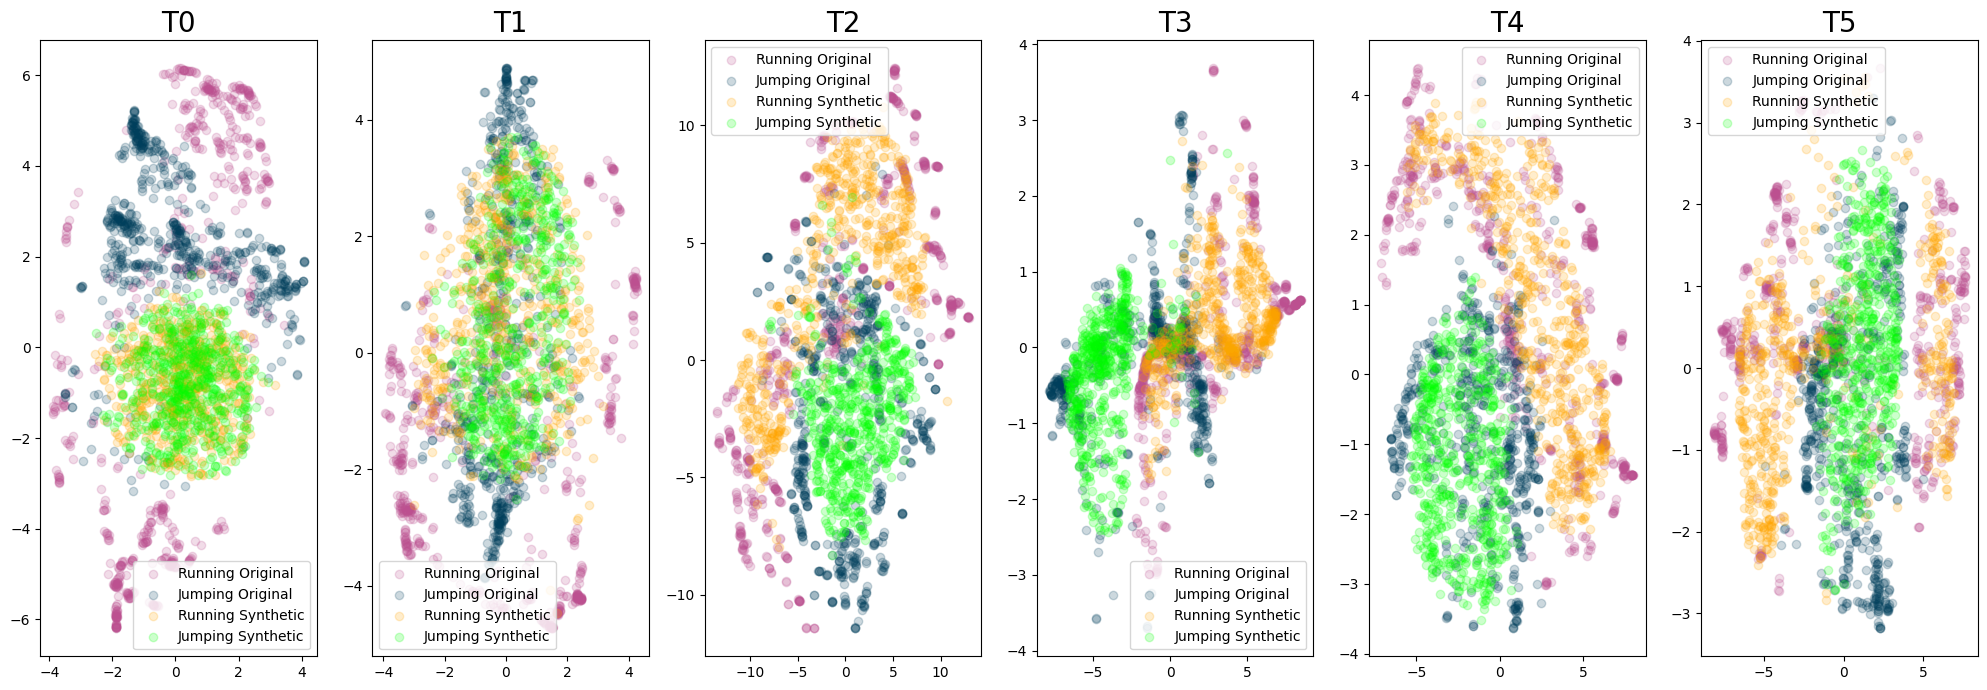

In [105]:
trainingVisualization(real_running, real_jumping, running_file_paths, jumping_file_paths)

/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

All epochs are 0
(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 1.814573
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.530762
[t-SNE] KL divergence after 300 iterations: 2.300696
(2400, 2)
All epochs are 0


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.630030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.312958
[t-SNE] KL divergence after 300 iterations: 1.985425
(2400, 2)
All epochs are 0


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 2.975972
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.397255
[t-SNE] KL divergence after 300 iterations: 1.795828
(2400, 2)


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

All epochs are 0
(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 3.167790
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.685001
[t-SNE] KL divergence after 300 iterations: 1.795889
(2400, 2)
All epochs are 0


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 3.213239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.244534
[t-SNE] KL divergence after 300 iterations: 1.817548
(2400, 2)


/workspaces/container-workspace/tts-gan/LoadSyntheticRunningJumping.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(Running_model_path, map_loc

Running checkpoint: 506
Jumping checkpoint: 834
(1200, 3, 1, 150)
(1200, 1)
(600, 150, 3) (600, 150, 3)
(2400, 150)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 3.290321
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.012054
[t-SNE] KL divergence after 300 iterations: 1.801601
(2400, 2)


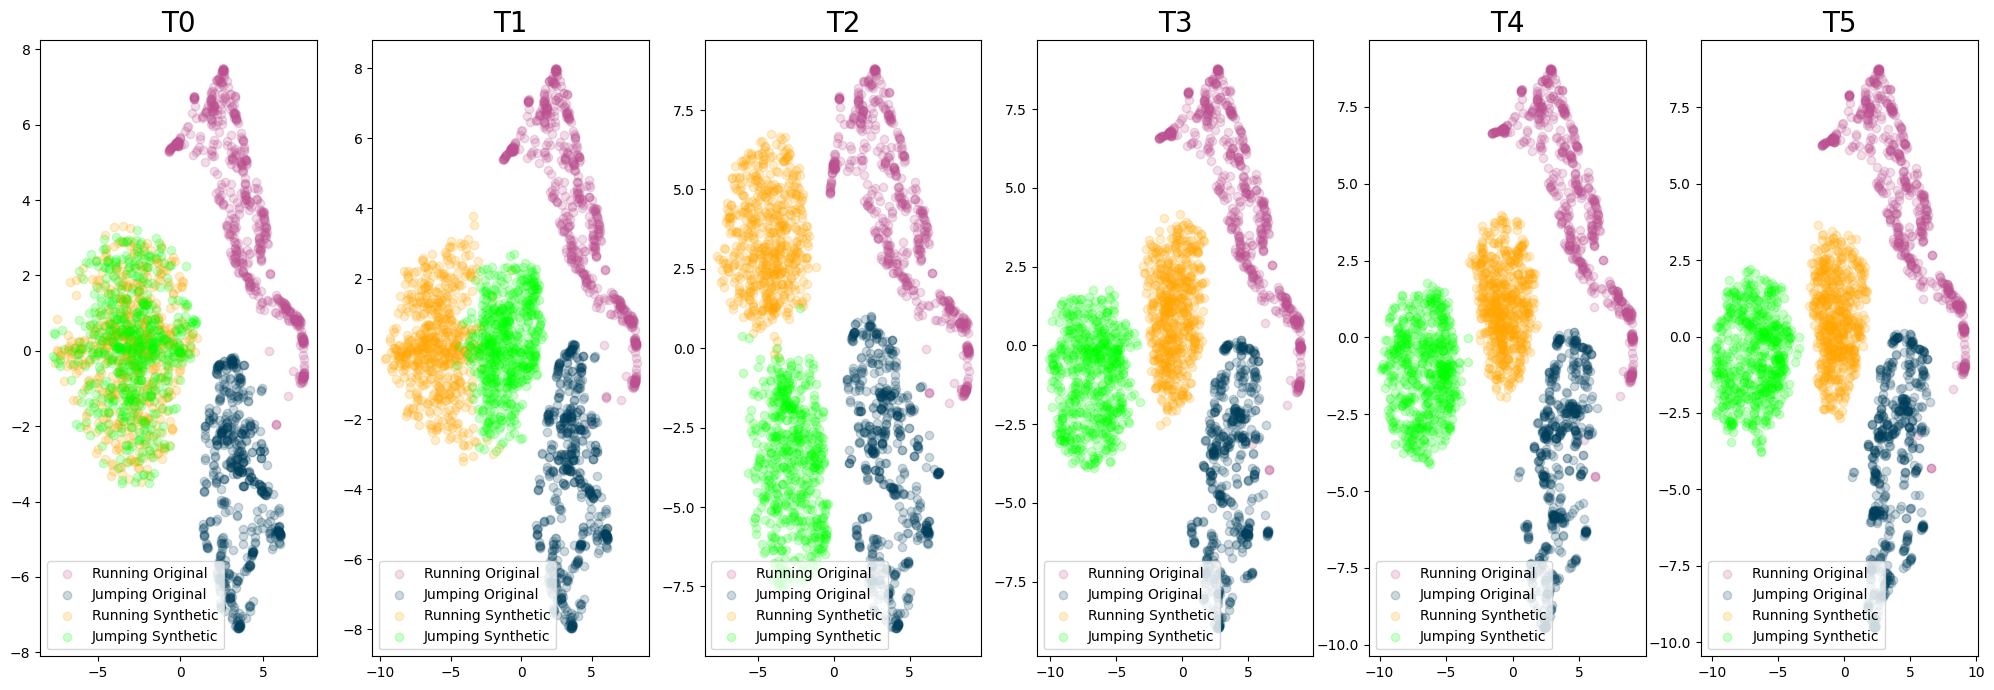

In [106]:
trainingVisualization(real_fft_running, real_fft_jumping, running_file_paths, jumping_file_paths, f=True)